In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bspline.BsplineLie import BsplineLie
import manifpy as lie

# Ensure matplotlib inline mode for Jupyter
%matplotlib inline

In [7]:
# Load the dataset
file_path = 'Data/load_data.csv'  # replace with the actual path to your dataset
path_data = pd.read_csv(file_path)

# Display the first few rows
path_data.head()

,timestamp,x,y,z,yaw,accel,steer
0,2377.313008,452203.077897,3.949655e+06,90.565314,-2.059803,0.0,-18.0
1,2377.412817,452203.077510,3.949655e+06,90.573598,-2.062122,0.0,-17.0
2,2377.512950,452203.072350,3.949655e+06,90.562182,-2.063811,0.0,-18.0
3,2377.612945,452203.072903,3.949655e+06,90.563098,-2.063259,0.0,-16.0
4,2377.728985,452203.068572,3.949655e+06,90.557390,-2.063614,0.0,-16.0


In [8]:
timestamp = path_data['timestamp']
X = path_data['x']
Y = path_data['y']
YAW = path_data['yaw']
Euclidian_control_points = list(zip(timestamp, X, Y, YAW))
SE2_control_points = []
start_idx = 10
samples = len(X) - start_idx
cnt = 0
for ts, x, y, yaw in Euclidian_control_points[start_idx:start_idx+samples]:
    SE2_control_points.append([ts, lie.SE2(x,y ,yaw)])


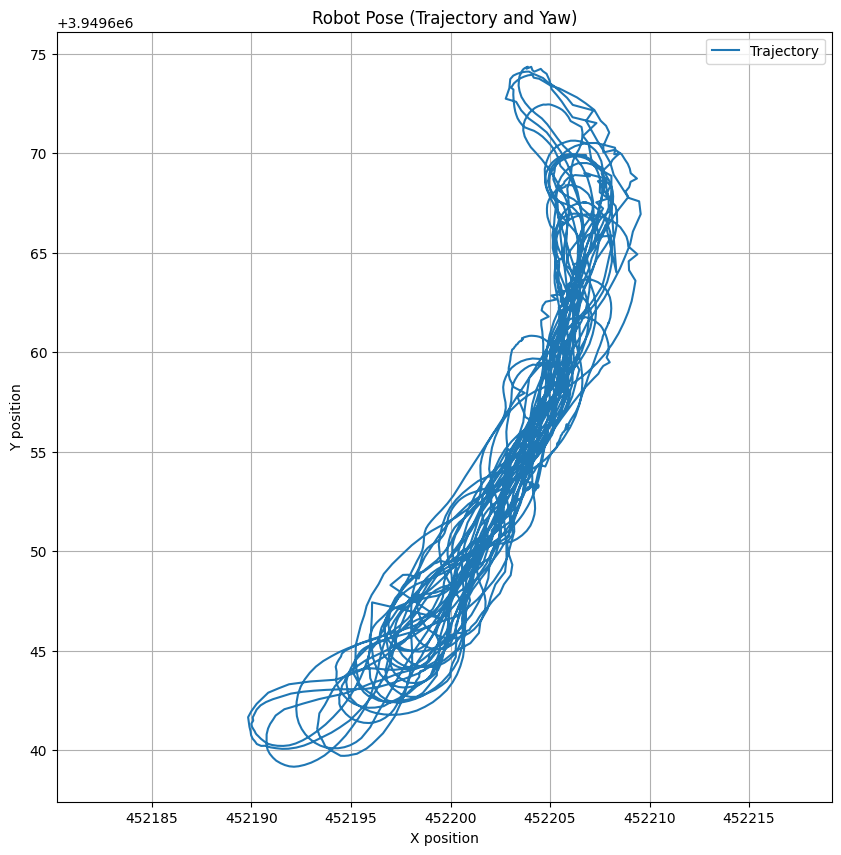

In [9]:
plt.figure(figsize=(10, 10))
plt.plot(X[:samples], Y[:samples], label="Trajectory")

# Add labels and title
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Robot Pose (Trajectory and Yaw)")
plt.legend()

# Show the plot
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling for both axes
plt.show()

In [10]:
spline = BsplineLie()
spline.feed_trajectory(SE2_control_points)
# Collect interpolated poses and their yaw angles

states = []
dot_states = []

for ts in timestamp[10:]:
    success, pose, vel = spline.get_velocity(ts)
    if success:
        z = np.array([pose.x(), pose.y(), pose.angle()])

        # x_dot, y_dot, yaw_dot = vel.x(), vel.y(), vel.angle()
        x_dot, y_dot = vel.x(), vel.y()
        yaw_dot = (pose.inverse() * vel.hat()).angle()
        dot_z = np.array([x_dot, y_dot,yaw_dot])

        states.append(z)
        dot_states.append(dot_z)
    else:
        print(f"Can't obtain the pose at {ts}")

states = np.array(states)
dot_states = np.array(dot_states)


[B-SPLINE]: control point dt = 0.100 (original dt of 0.100)
[B-SPLINE]: trajectory start time = 2378.313155
[B-SPLINE]: trajectory end time = 2780.833995
[B-SPLINE]: start trajectory time of 2378.513166
Can't obtain the pose at 2378.313155168


TypeError: unsupported operand type(s) for *: 'manifpy._bindings.SE2' and 'manifpy._bindings.SE2Tangent'

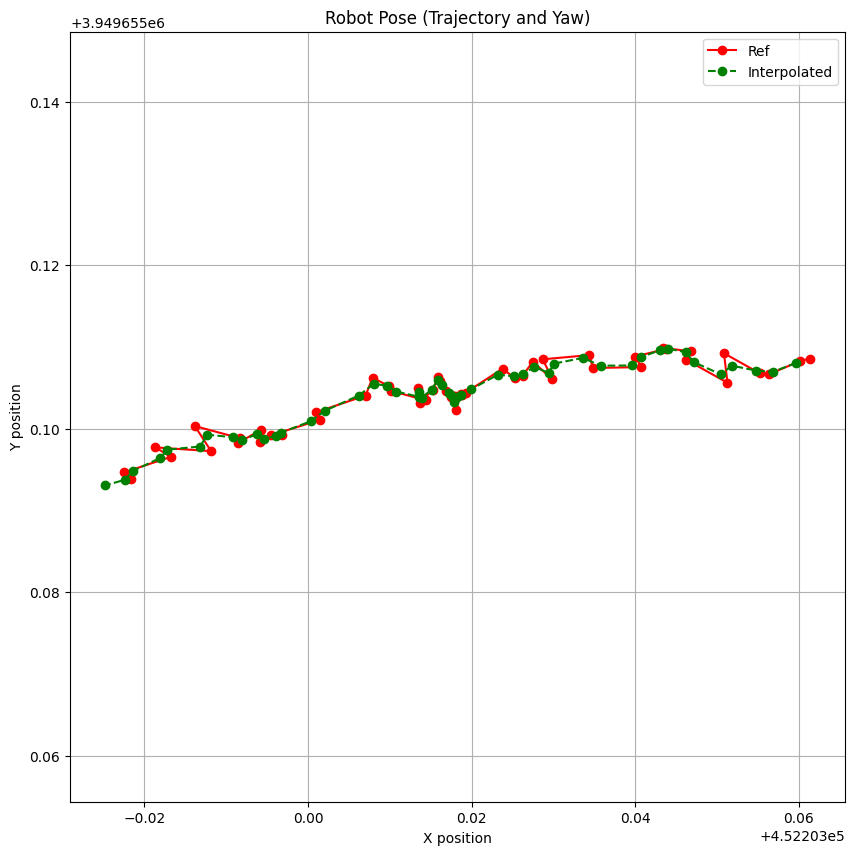

In [ ]:
vis_samples = 50
plt.figure(figsize=(10, 10))
plt.plot(X[start_idx:start_idx+vis_samples], Y[start_idx:start_idx+vis_samples], color='red', marker='o', label="Ref")
plt.plot(states[:vis_samples,0], states[:vis_samples, 1],color='green', marker='o', linestyle='--', label="Interpolated")

# Add labels and title
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Robot Pose (Trajectory and Yaw)")
plt.legend()

# Show the plot
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling for both axes
plt.show()

In [ ]:
# Constants
states_dof = 3  # x, y, yaw
h = 10  # history length
batch_size = 64  # Define batch size for DataLoader
train_val_split_ratio = 0.8  # 80% train, 20% validation

# Prepare the data
action_columns = ['accel', 'steer']
actions = path_data[action_columns].values

# Create sequences with history length h
input_sequences = []
output_sequences = []

for i in range(len(states) - h):
    input_seq = np.concatenate((states[i:i + h], actions[i:i + h]), axis=1).flatten()
    output_seq = dot_states[i + h]  # The next state to predict
    input_sequences.append(input_seq)
    output_sequences.append(output_seq)

# Convert to NumPy arrays and then to PyTorch tensors
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

# Convert to PyTorch tensors
inputs = torch.tensor(input_sequences, dtype=torch.float32)
outputs = torch.tensor(output_sequences, dtype=torch.float32)
# Check shapes
print(inputs.shape, outputs.shape)  # (samples, h * (|x| + |a|)), (samples, |x|)

# Dataset and DataLoader Setup
dataset = TensorDataset(inputs, outputs)

# Split dataset into train, validation, and test sets (80-10-10 split)
train_size = int(len(dataset) * train_val_split_ratio)
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

torch.Size([4013, 50]) torch.Size([4013, 3])


In [ ]:
# Define the model
class RobotDynamicsModel(nn.Module):
    def __init__(self, input_size):
        super(RobotDynamicsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 2 * input_size)
        self.fc2 = nn.Linear(2 * input_size, 4 * input_size)
        self.fc3 = nn.Linear(4 * input_size, 6 * input_size)
        self.fc4 = nn.Linear(6 * input_size, 2 * input_size)
        self.output_layer = nn.Linear(2 * input_size, states_dof)  # Output size is |x| = 3

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = h * (states_dof + len(action_columns))  # h * (|x| + |a|)
model = RobotDynamicsModel(input_size)
model

RobotDynamicsModel(
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=3, bias=True)
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the evaluate function to calculate loss on validation/test sets
def evaluate(loader):
    model.eval()  # Set model to evaluation mode
    total_loss, total_samples = 0, 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            total_loss += loss.item() * len(targets)
            total_samples += len(targets)

    return total_loss / total_samples  # Return average loss

In [ ]:
# Training loop with validation
best_val_loss = float('inf')  # Initialize best validation loss to infinity
train_losses, val_losses = [], []
epochs = 10000

for epoch in range(epochs):
    model.train()  # Set model to training mode

    train_loss = 0  # Accumulate training loss
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        predictions = model(inputs)
        loss = criterion(predictions, targets)  # Compute loss

        # Backward pass and optimization
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item() * len(targets)  # Accumulate loss

    # Calculate average train loss for the epoch
    train_loss /= len(train_set)

    # Evaluate on validation set
    val_loss = evaluate(val_loader)
    # Track losses per epoch
    if val_loss < 10 and train_loss < 10:
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model at Epoch {epoch + 1} with Validation Loss: {val_loss:.4f}")

    # Print progress every 1000 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Evaluate on the test set after training completes
test_loss = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Saved Best Model at Epoch 1 with Validation Loss: 977609.3904
Saved Best Model at Epoch 2 with Validation Loss: 829.6319
Saved Best Model at Epoch 3 with Validation Loss: 30.0650
Saved Best Model at Epoch 4 with Validation Loss: 6.8170
Saved Best Model at Epoch 5 with Validation Loss: 6.2901
Saved Best Model at Epoch 6 with Validation Loss: 6.2576
Saved Best Model at Epoch 7 with Validation Loss: 6.1595
Saved Best Model at Epoch 10 with Validation Loss: 6.0950
Epoch [10/10000], Train Loss: 6.6766, Val Loss: 6.0950
Saved Best Model at Epoch 19 with Validation Loss: 5.5759
Epoch [20/10000], Train Loss: 5.9015, Val Loss: 7.0509
Epoch [30/10000], Train Loss: 5.9854, Val Loss: 10.0830
Saved Best Model at Epoch 32 with Validation Loss: 5.1594
Saved Best Model at Epoch 38 with Validation Loss: 4.8615
Epoch [40/10000], Train Loss: 6.5813, Val Loss: 14.7784
Epoch [50/10000], Train Loss: 122.2082, Val Loss: 15.8071
Epoch [60/10000], Train Loss: 63.6168, Val Loss: 524.0917
Epoch [70/10000], Train

KeyboardInterrupt: 

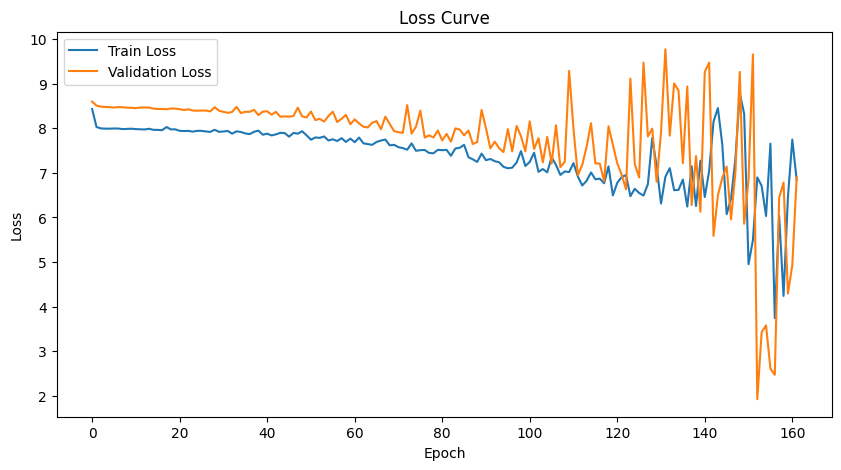

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()